<h1>Installing Dependencies</h1>

In [1]:
!pip install -r requirements.txt

<h1>Importing Libraries & GPU Setup</h1>


In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import keras

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

print("Num of GPUs available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

Num of GPUs available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5195566694861869037
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1733715559
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8518431841167230871
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


<h1>Loading Dataset</h1>

In [3]:
# Loading the dataset

train_dir = r'C:\Users\skfar\Desktop\major_project\alzheimers_mri_dataset\AugmentedAlzheimerDataset'

MildDemented_dir = r'C:\Users\skfar\Desktop\major_project\alzheimers_mri_dataset\AugmentedAlzheimerDataset\MildDemented'
ModerateDemented_dir = r'C:\Users\skfar\Desktop\major_project\alzheimers_mri_dataset\AugmentedAlzheimerDataset\ModerateDemented'
NonDemented_dir = r'C:\Users\skfar\Desktop\major_project\alzheimers_mri_dataset\AugmentedAlzheimerDataset\NonDemented'
VeryMildDemented_dir = r'C:\Users\skfar\Desktop\major_project\alzheimers_mri_dataset\AugmentedAlzheimerDataset\VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])


Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  C:\Users\skfar\Desktop\major_project\alzheimer...  Mild Demented
1  C:\Users\skfar\Desktop\major_project\alzheimer...  Mild Demented
2  C:\Users\skfar\Desktop\major_project\alzheimer...  Mild Demented
3  C:\Users\skfar\Desktop\major_project\alzheimer...  Mild Demented
4  C:\Users\skfar\Desktop\major_project\alzheimer...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


<h1>Creating Train, Validation, and Test Sets</h1>

In [4]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(27187, 2)
(10196, 2)
(6797, 2)
(23788, 2)


<h1>Image Data Preprocessing and Augmentation</h1>

In [5]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=32,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


<h1>Visualizing Sample Images</h1>

In [6]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

<h1>Defining the Model Architecture (ResNet50)</h1>

In [7]:
# Import required libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization

# Initialize the ResNet50 base model (without the top)
resnet_base = ResNet50(include_top=False, pooling='avg', weights='imagenet')
resnet_base.trainable = False  # Freeze the ResNet50 base

# Define the full model
model = Sequential([
    resnet_base,  # Use the pre-trained ResNet50 model
    Flatten(),
    BatchNormalization(),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')  # Final output layer for 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1024)              2

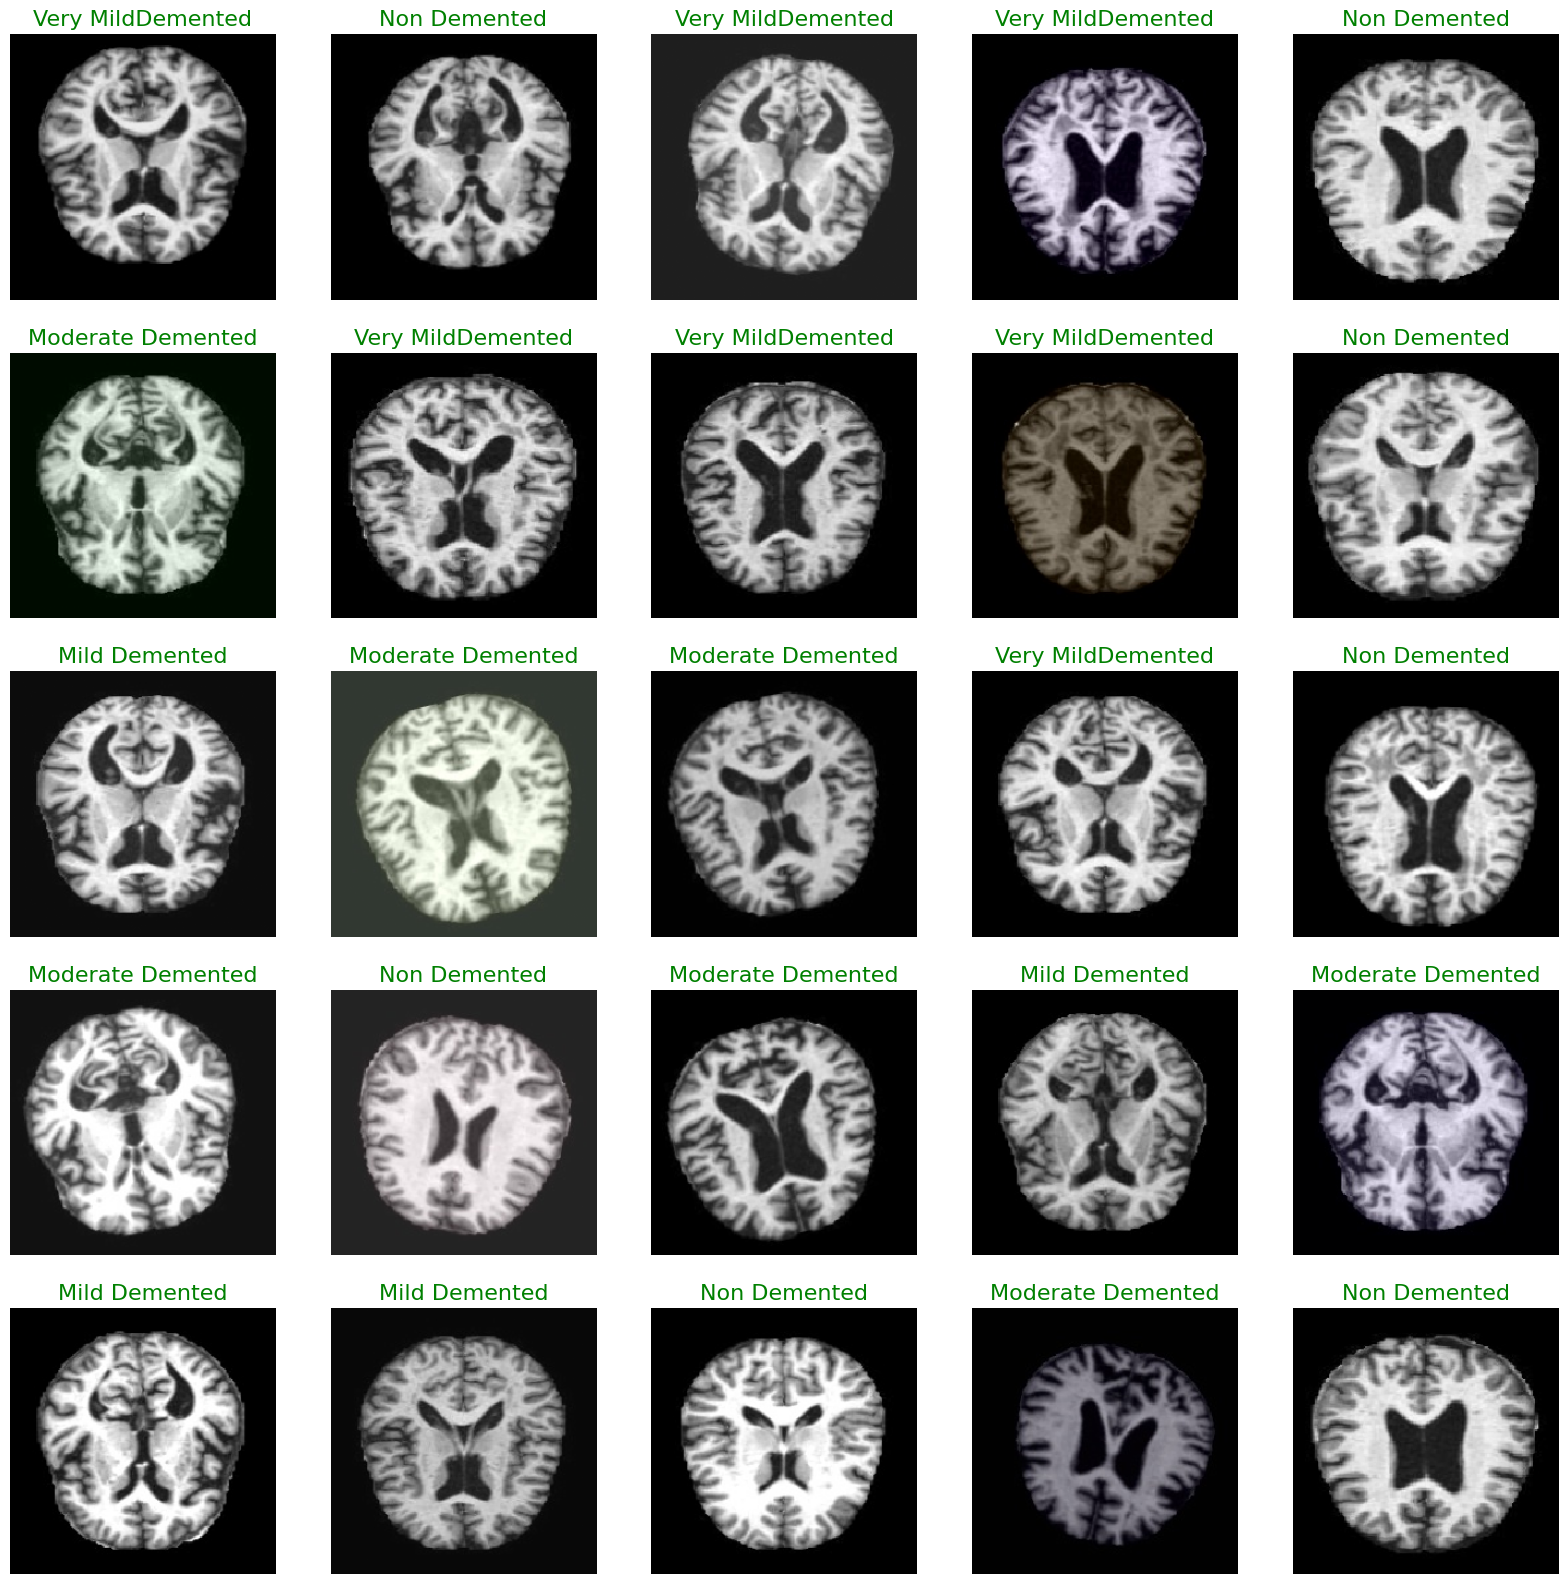

In [8]:
show_brain_images(train)

<h1>Defining Callbacks & Model Training</h1>

In [9]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=3,                
    restore_best_weights=True, 
    verbose=1
)

# Define the ModelCheckpoint callback to save the model after every 'x' epochs
checkpoint_callback = ModelCheckpoint(
    'model_epoch_{epoch:02d}.keras',  
    save_freq='epoch',  
    save_best_only=False,  
    verbose=1  
)

batch_size = 16

# Train the model with the checkpoint and early stopping callbacks
with tf.device('/GPU:0'):
    history = model.fit(
        train, 
        batch_size=batch_size,
        epochs=10, 
        validation_data=val, 
        validation_freq=1, 
        callbacks=[early_stopping, checkpoint_callback],  # Add both callbacks here
    )


Epoch 1/10
850/850 [==============================] - ETA: 0s - loss: 0.9747 - accuracy: 0.5982
Epoch 1: saving model to model_epoch_01.keras
850/850 [==============================] - 173s 193ms/step - loss: 0.9747 - accuracy: 0.5982 - val_loss: 0.7006 - val_accuracy: 0.7019
Epoch 2/10
850/850 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.7049
Epoch 2: saving model to model_epoch_02.keras
850/850 [==============================] - 161s 189ms/step - loss: 0.6905 - accuracy: 0.7049 - val_loss: 0.7849 - val_accuracy: 0.7110
Epoch 3/10
850/850 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.7583
Epoch 3: saving model to model_epoch_03.keras
850/850 [==============================] - 164s 193ms/step - loss: 0.5837 - accuracy: 0.7583 - val_loss: 0.5508 - val_accuracy: 0.7771
Epoch 4/10
850/850 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.8039
Epoch 4: saving model to model_epoch_04.keras
850/850 [==================

<h1>Saving the Trained Model</h1>

In [10]:
#Save the model
model.save('resnet_final_model.keras')

<h1>Model Evaluation & Generating Predictions</h1>

In [11]:
# Evaluate the model
model = load_model('resnet_final_model.keras')
model.evaluate(test, verbose=1)

# Predict
pred = model.predict(test)
pred_labels = np.argmax(pred, axis=1)

# Label decoding
labels = train.class_indices
index_to_class = {v: k for k, v in labels.items()}  # This maps int → label name

# Decode predictions
pred_class_names = [index_to_class[i] for i in pred_labels]

# Get true labels (as indices)
y_test_indices = test.classes  # test_images.labels might be strings — this gives int class indices

# Decode true class names
y_test_class_names = [index_to_class[i] for i in y_test_indices]

319/319 [==============================] - 45s 138ms/step


<h1>Visualizing Accuracy and Loss</h1>

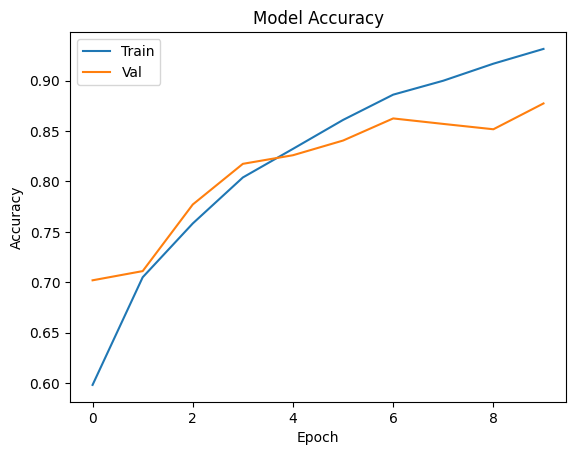

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

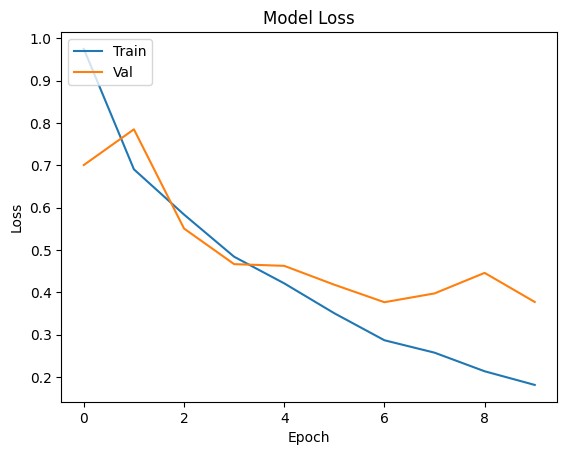

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

<h1>Confusion Matrix</h1>

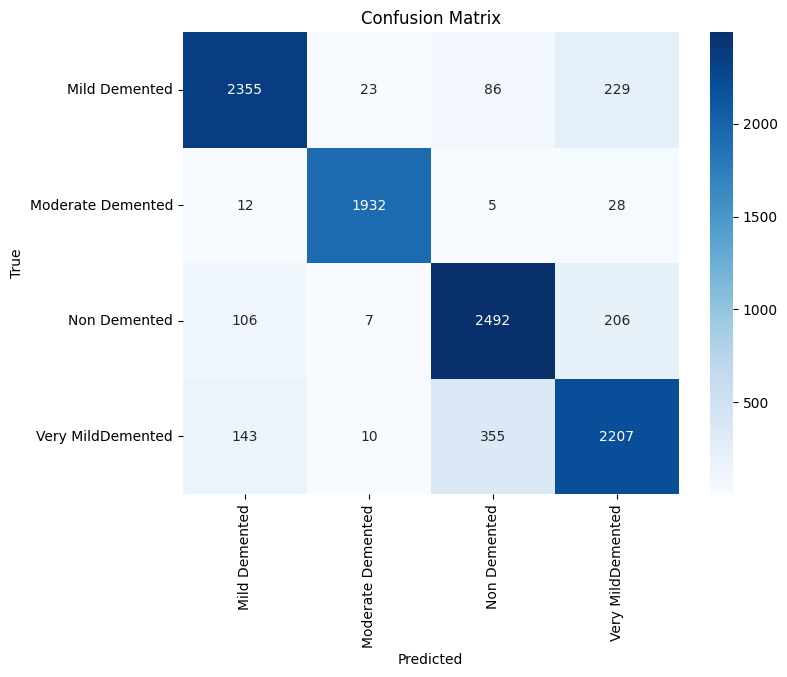

In [17]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_indices, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=index_to_class.values(), 
            yticklabels=index_to_class.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


<h1>Classification Report</h1>

In [18]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test_class_names, pred_class_names))


Classification Report:

                   precision    recall  f1-score   support

    Mild Demented       0.90      0.87      0.89      2693
Moderate Demented       0.98      0.98      0.98      1977
     Non Demented       0.85      0.89      0.87      2811
Very MildDemented       0.83      0.81      0.82      2715

         accuracy                           0.88     10196
        macro avg       0.89      0.89      0.89     10196
     weighted avg       0.88      0.88      0.88     10196



In [19]:
# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_class_names, pred_class_names)
print("Accuracy of the Model:", "{:.2f}%".format(acc * 100))

Accuracy of the Model: 88.13%


<h1>ROC Curve Per Class</h1>

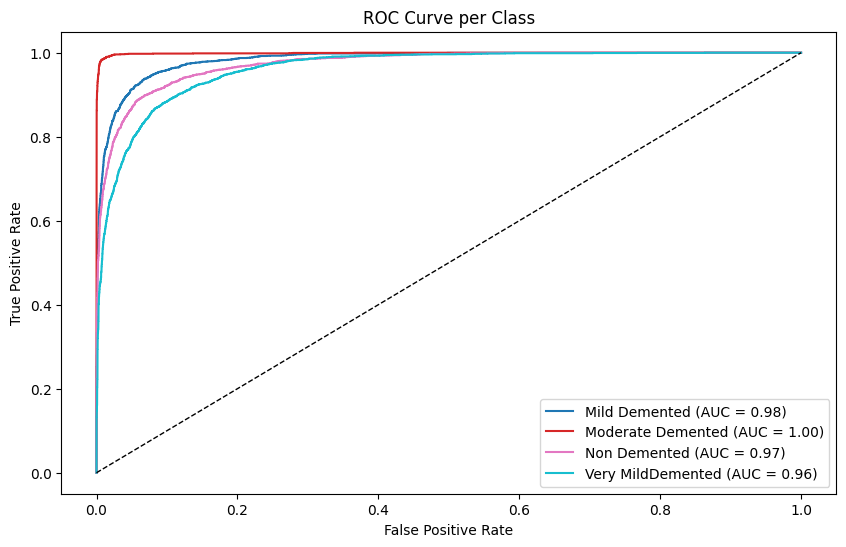

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# --- ROC Curve per Class ---
y_test_bin = label_binarize(y_test_indices, classes=list(range(len(labels))))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    class_name = index_to_class[i]
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc="lower right")
plt.show()

<h1>Sample Predictions Visualization</h1>

1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.49803925].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.60784316].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to 

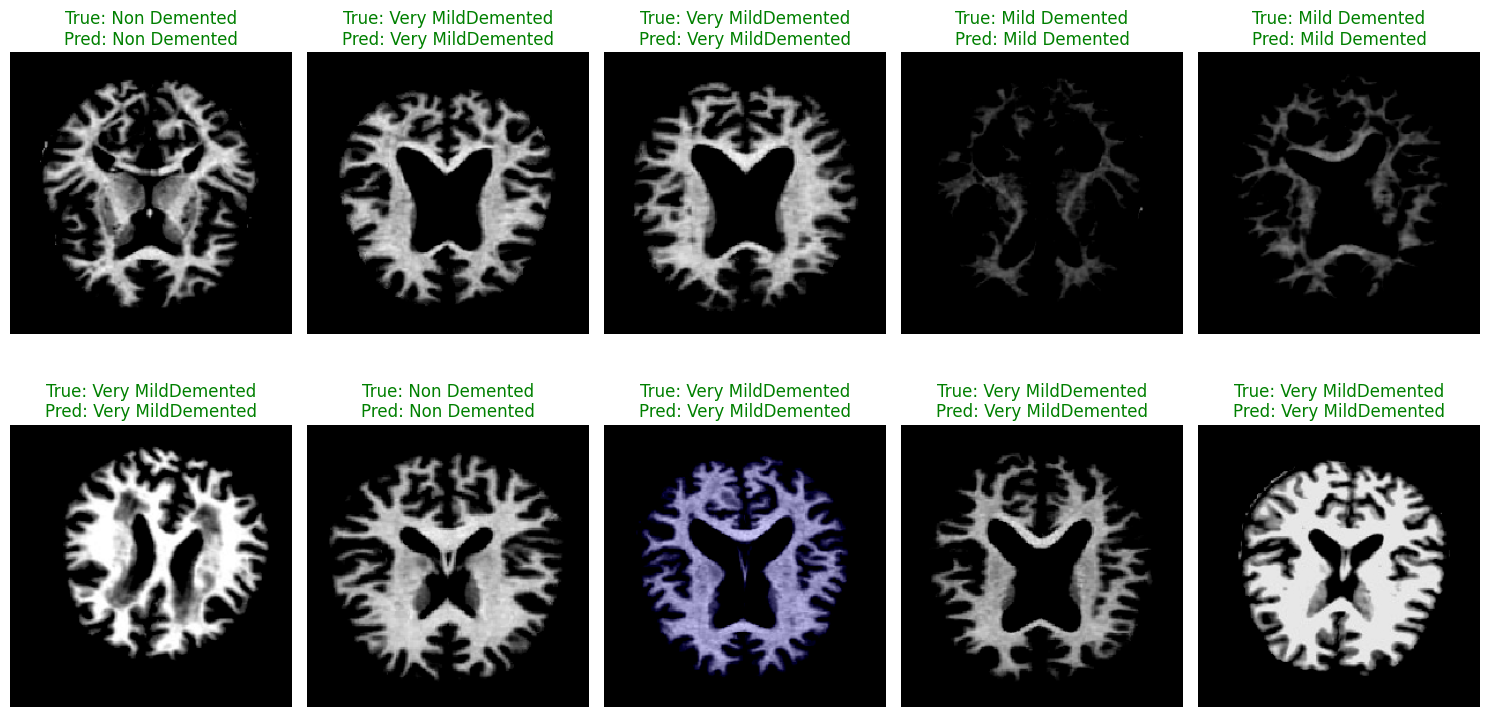

In [23]:
x_test_batch, y_test_batch = next(test)
y_true_batch = np.argmax(y_test_batch, axis=1)
y_pred_batch = np.argmax(model.predict(x_test_batch), axis=1)

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test_batch[i])
    plt.axis('off')
    true_label = index_to_class[y_true_batch[i]]
    pred_label = index_to_class[y_pred_batch[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
plt.tight_layout()
plt.show()